# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Read Data as Numpy Array

In [2]:
# load training data
training_data = np.load("Data/training_data.npy", allow_pickle=True)
print("training data shape: {}".format(training_data.shape))

# load validation data
validation_data = np.load("Data/validation_data.npy", allow_pickle=True)
print("validation data shape: {}".format(validation_data.shape))

training data shape: (170, 2)
validation data shape: (158, 2)


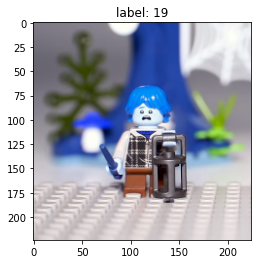

In [3]:
# plot example image
plt.imshow(training_data[0][0])
plt.title("label: {}".format(training_data[0][1].item()));

In [4]:
# augment and normalize images
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(5),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])    
])

transforms_val = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])    
])

In [5]:
class MyDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = data
        self.target = target
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Batch idx 0, data shape torch.Size([10, 3, 224, 224]), target shape torch.Size([10, 1])
Batch idx 1, data shape torch.Size([10, 3, 224, 224]), target shape torch.Size([10, 1])
Batch idx 2, data shape torch.Size([10, 3, 224, 224]), target shape torch.Size([10, 1])
Batch idx 3, data shape torch.Size([10, 3, 224, 224]), target shape torch.Size([10, 1])
Batch idx 4, data shape torch.Size([10, 3, 224, 224]), target shape torch.Size([10, 1])
Batch idx 5, data shape torch.Size([10, 3, 224, 224]), target shape torch.Size([10, 1])
Batch idx 6, data shape torch.Size([10, 3, 224, 224]), target shape torch.Size([10, 1])
Batch idx 7, data shape torch.Size([10, 3, 224, 224]), target shape torch.Size([10, 1])
Batch idx 8, data shape torch.Size([10, 3, 224, 224]), target shape torch.Size([10, 1])
Batch idx 9, data shape torch.Size([10, 3, 224, 224]), target shape torch.Size([10, 1])
Batch idx 10, data shape torch.Size([10, 3, 224, 224]), target shape torch.Size([10, 1])
Batch idx 11, data shape torch.

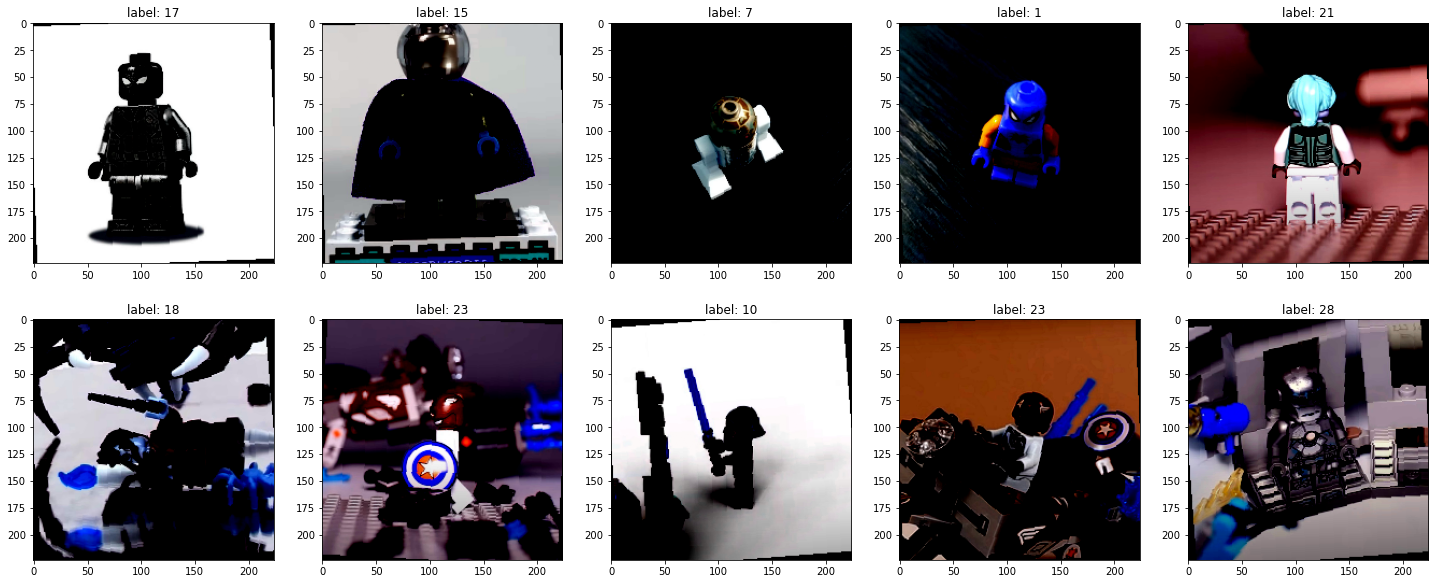

In [6]:
train_dataset = MyDataset(training_data[:,0][:], training_data[:,1][:], transform=transforms)
valid_dataset = MyDataset(validation_data[:,0][:], validation_data[:,1][:], transform=transforms_val)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=10)


for batch_idx, (data, target) in enumerate(train_loader):
    print('Batch idx {}, data shape {}, target shape {}'.format(batch_idx, data.shape, target.shape))
    image_size = data.shape[3]
    
# plot images from last batch
fig, axes = plt.subplots(2,5, figsize=(25,10))

for i, ax in enumerate(axes.flatten()): 
    tmp = data[i].numpy().swapaxes(0,1)
    tmp1 = tmp.swapaxes(1,2)
    
    ax.imshow(tmp1)
    ax.set_title(f"label: {target[i][0]}");

# Build the Model

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5) # input (channels), output, kernel size
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        self.conv4 = nn.Conv2d(128, 256, 5)
        # create some random data to figure out the number of the folowing fc layer
        x = torch.randn(3, image_size, image_size).view(-1, 3, image_size, image_size) 
        self._to_linear = None
        self.convs(x)
        self.fc1 = nn.Linear(self._to_linear, 512) 
        self.fc2 = nn.Linear(512, 30) # 30 classes
    
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv4(x)), (2,2))
        
        #print(x[0].shape)
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2] #consider x as a batch and grab 1. element
        
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear) # flatten x after conv layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

net = Net()

In [8]:
net

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=25600, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=30, bias=True)
)

In [9]:
optimizer = optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Train the Model

In [10]:
# number of epochs to train the model
n_epochs = 20
# track change in validation loss
valid_loss_min = np.Inf 

for epoch in range(n_epochs):
    
    # monitor train/valid loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ################
    # train the model
    ################
    net.train() # prep model for training
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = net(data)
        # calculate the loss
        loss = criterion(output, np.squeeze(target))
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ##########
    # validate the model
    ##########
    net.eval()
    for data, target in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = net(data)
        # calculate the batch loss
        loss = criterion(output, np.squeeze(target))
        # update average validation loss
        valid_loss += loss.item()*data.size(0)
        
    # calculate average losses over an epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss < valid_loss_min:
        valid_loss_min = valid_loss
        torch.save(net.state_dict(), 'model_lego_pytorch.pt')
    else:
        print("Validation loss did not decrease")
    

Epoch: 0 	Training Loss: 270.231295 	Validation Loss: 3.392815
Epoch: 1 	Training Loss: 3.392638 	Validation Loss: 3.379134
Epoch: 2 	Training Loss: 3.380639 	Validation Loss: 3.370524
Epoch: 3 	Training Loss: 3.377059 	Validation Loss: 3.364138
Epoch: 4 	Training Loss: 3.371861 	Validation Loss: 3.361329
Epoch: 5 	Training Loss: 3.364809 	Validation Loss: 3.361151
Epoch: 6 	Training Loss: 3.366565 	Validation Loss: 3.358457
Epoch: 7 	Training Loss: 3.363393 	Validation Loss: 3.357840
Epoch: 8 	Training Loss: 3.362695 	Validation Loss: 3.357802
Epoch: 9 	Training Loss: 3.362833 	Validation Loss: 3.358452
Validation loss did not decrease
Epoch: 10 	Training Loss: 3.365369 	Validation Loss: 3.357640
Epoch: 11 	Training Loss: 3.362290 	Validation Loss: 3.357037
Epoch: 12 	Training Loss: 3.361696 	Validation Loss: 3.357984
Validation loss did not decrease
Epoch: 13 	Training Loss: 3.361072 	Validation Loss: 3.355954
Epoch: 14 	Training Loss: 3.361673 	Validation Loss: 3.355927
Epoch: 15 	T

# Load Model with lowest Validation Loss

In [11]:
net.load_state_dict(torch.load('model_lego_pytorch.pt'))

<All keys matched successfully>

# Accuracy on Validation set

In [12]:
valid_loss = 0.0
batch_size = 10

correct_valid = list(0 for i in range(30))
total_valid = list(0 for i in range(30))


net.eval()
for batch_idx, (data, target) in enumerate(valid_loader):
    
    # forward pass: compute predicted outputs by passing inputs to the model
    output = net(data)
    # calculate the batch loss
    loss = criterion(output, np.squeeze(target))
    # update validation loss 
    valid_loss += loss.item()*data.size(0) # loss * batchsize
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    #correct = [pred == np.squeeze(target)]#
    correct = pred.eq(np.squeeze(target))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        length_batch = len(target)
        # last batch might be smaller
        if i >= length_batch:
            break
        label = target[i].item()
        correct_valid[label] += correct[i].item()
        total_valid[label] += 1
        
# average loss
valid_loss = valid_loss/len(valid_loader.dataset)
print('Validation Loss: {:.6f}\n'.format(valid_loss))

for i in range(30):
    if total_valid[i] > 0:
        print('Validation Accuracy of %5s: %2d%% (%2d/%2d)' % (
            i, 100 * correct_valid[i] / total_valid[i],
            np.sum(correct_valid[i]), np.sum(total_valid[i])))
    else:
        print('Validation Accuracy of %5s: N/A (no training examples)' % (i))

print('\nValidation Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(correct_valid) / np.sum(total_valid),
    np.sum(correct_valid), np.sum(total_valid)))

Validation Loss: 3.355880

Validation Accuracy of     0: N/A (no training examples)
Validation Accuracy of     1:  0% ( 0/ 5)
Validation Accuracy of     2:  0% ( 0/ 5)
Validation Accuracy of     3:  0% ( 0/ 5)
Validation Accuracy of     4:  0% ( 0/ 5)
Validation Accuracy of     5:  0% ( 0/ 5)
Validation Accuracy of     6: 100% ( 5/ 5)
Validation Accuracy of     7:  0% ( 0/ 5)
Validation Accuracy of     8:  0% ( 0/ 6)
Validation Accuracy of     9:  0% ( 0/ 7)
Validation Accuracy of    10:  0% ( 0/ 5)
Validation Accuracy of    11:  0% ( 0/ 4)
Validation Accuracy of    12:  0% ( 0/ 4)
Validation Accuracy of    13:  0% ( 0/ 4)
Validation Accuracy of    14:  0% ( 0/ 4)
Validation Accuracy of    15:  0% ( 0/ 4)
Validation Accuracy of    16:  0% ( 0/ 4)
Validation Accuracy of    17:  0% ( 0/ 4)
Validation Accuracy of    18:  0% ( 0/ 6)
Validation Accuracy of    19:  0% ( 0/ 6)
Validation Accuracy of    20:  0% ( 0/ 7)
Validation Accuracy of    21:  0% ( 0/ 7)
Validation Accuracy of    22:  0%

# Example Predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

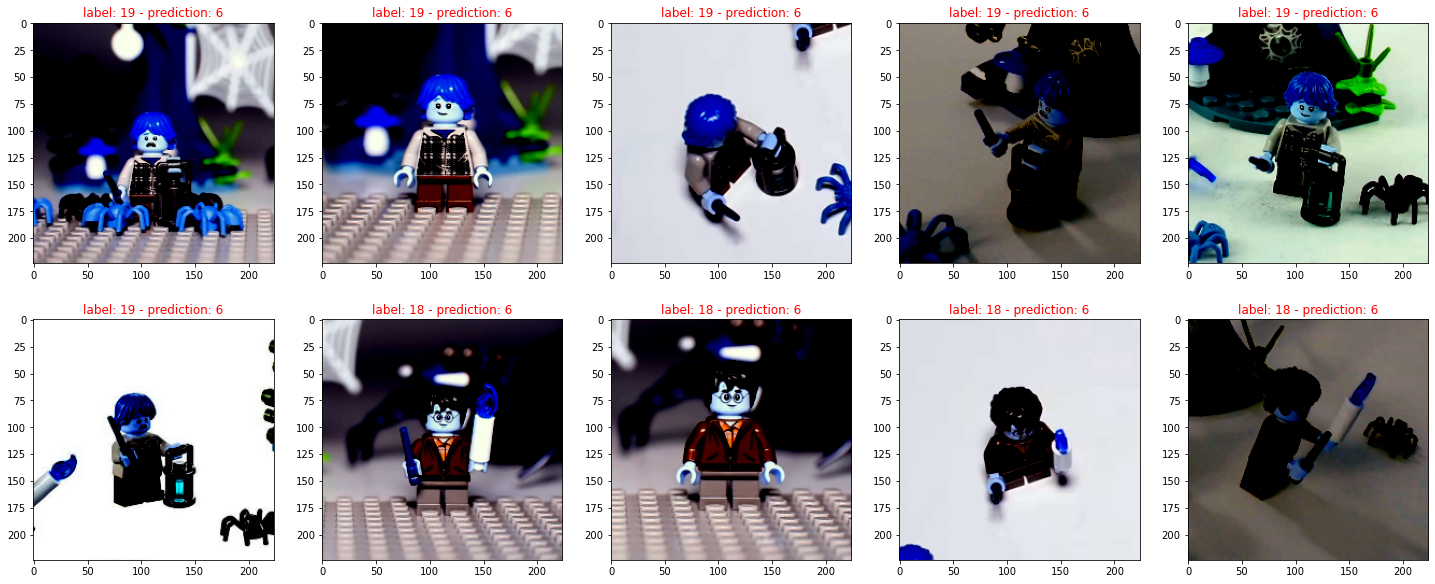

In [13]:
# obtain one batch of validation images
dataiter = iter(valid_loader)
images, labels = dataiter.next()
images.numpy()

# get sample outputs
output = net(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
preds.numpy()

fig, axes = plt.subplots(2,5, figsize=(25,10))

for i, ax in enumerate(axes.flatten()):
    tmp = images[i].numpy().swapaxes(0,1) # swap axes, so that channel is in first dimension
    tmp1 = tmp.swapaxes(1,2)
    
    ax.imshow(tmp1)
    ax.set_title(f'label: {labels[i].item()} - prediction: {preds[i]}', 
                color=("green" if preds[i]==labels[i].item() else "red"))

# ToDo

* Model should to be tested on an independend test set
* Hyperparameter tuning
* Try if pretrained Model works better